## Package Description

`bmdrc` is a python library for calculating **B**ench**m**ark **D**ose **R**esponse **C**urves. This tutorial will take users through the library using a dichotomous (binary response) example. `bmdrc` is broken up into five modules 

1. *Input Data Module:* Import data into the python library.

2. *Pre-Processing Module:* Combine and remove endpoints as needed.

3. *Filtering Modules:* Apply recommended filters from the EPA and statistics experts.

4. *Model Fitting Modules:* Fit recommended models from the EPA and experts. The best fit model is autoselected for you.

5. *Output Modules:* Select tables to output as csvs. View plots in a HTML report.

First, install the package from pip using: 

`pip install bmdrc`

Or from github using: 

`pip install git+https://github.com/PNNL-CompBio/bmdrc`

## Datatype Description

**Dichotomous Data**

- *BinaryClass* The `BinaryClass` object contains specific pre-processing and filtering functions that pertain to plates and wells. Each value should be a 0, 1, or NA, and *bmdrc* will caculate the response column. The following columns are needed for data in long and wide format: chemical, plate, well, concentration. The following columns are only needed for data in wide format: endpoint, value. 

- *ProportionalClass* If your data does not contain plates and wells, the `ProportionalClass` object only requires a chemical, endpoint, concentration, and response (a proportion ranging from 0 to 1). Data must be in long format. 

- *LPRClass* In the `LPRClass`, larval photomotor response data can be converted to dichotomous as described in [Thomas et al 2019](https://www.sciencedirect.com/science/article/pii/S2468111318300732). Data must be in long format and contain the following columns: chemical, plate, well, concentration, time, and value. Users must specify the time between cycles, the cooldown time between cycles, and whether to start with a light or dark cycle. If this format does not fit your data nicely, please report it to the issues tab. 

**Continuous Data**

- *ContinuousClass* The `ContinuousClass` object requires only four columns: chemical, endpoint, concentration, and response (a continuous variable with any range). All selected models support negative numbers and zeroes. NA values are automatically filtered out. Optionally, an ANOVA can be fit to determine if there's differences in concentrations, with checks to ensure an ANOVA model is appropriate for the given dataset.


In [1]:
# Load local installation of libraries
import bmdrc
import pandas as pd

## Module 1: Input Data

The first step to using the bmdrc python library is to properly format the data. Here we will use the `ContinuousClass` function, which requires a pandas DataFrame with the following columns: chemical, endpoint, concentration, and response.

In [2]:
from bmdrc.ContinuousClass import ContinuousClass

con = ContinuousClass(
    df = pd.read_table("../data/Continuous.txt"), # Input is a pandas DataFrame
    chemical = "Chemical ID", # The name of the chemical column 
    endpoint = "Endpoint", # The name of the column with endpoints
    concentration = "Concentration_uM", # The name of the concentration column
    response = "Measurement" # The name of the column with a numeric response column
)

## Module 2: Pre-Processing

Endpoints that should not be modeled can be removed at this step. 

#### Remove Endpoints

In [3]:
# Remove Endpoint 5
con.remove_endpoints(endpoint_name = "Endpoint5")
con.df[con.endpoint].unique()

/Users/degn400/Git_Repos/bmdrc/.venv/lib/python3.13/site-packages/bmdrc/ContinuousClass.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theDF["plate"] = "NoPlate" # There is no plate information to track


array(['Endpoint1', 'Endpoint2', 'Endpoint3', 'Endpoint4', 'Endpoint6'],
      dtype=object)

## Module 3: Filtering

#### Minimum Concentration Filter

The assumption is that there should be at least 3 non-zero concentration measurements to fit a curve. 

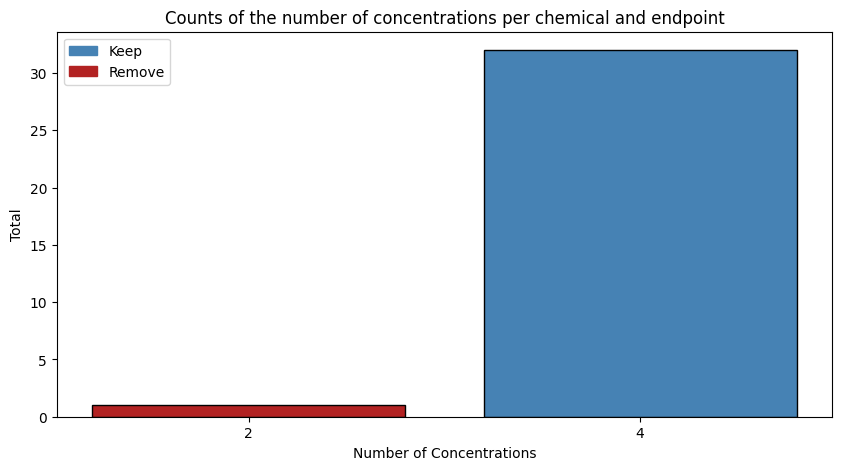

In [4]:
# Set the percentage and build the diagnostic plot, but don't actually apply the filter. 
con.filter_min_concentration(count = 3, apply = False, diagnostic_plot = True)

In [5]:
# Let's see a summary table
con.filter_min_concentration_df

,NumConc,Count,Filter
0,4,32,Keep
1,2,1,Remove


In [6]:
# Apply the filter with defaults
con.filter_min_concentration(apply = True)

### Correlation Score Filter

To fit a curve, we expect the response to increase or decrease with dose. Here, an absolute value of the EPA recommended threshold of 0.2 is used. Note that the default parameter for direction is `below` and need to be set to `between` for between the threshold and -1 * threshold.

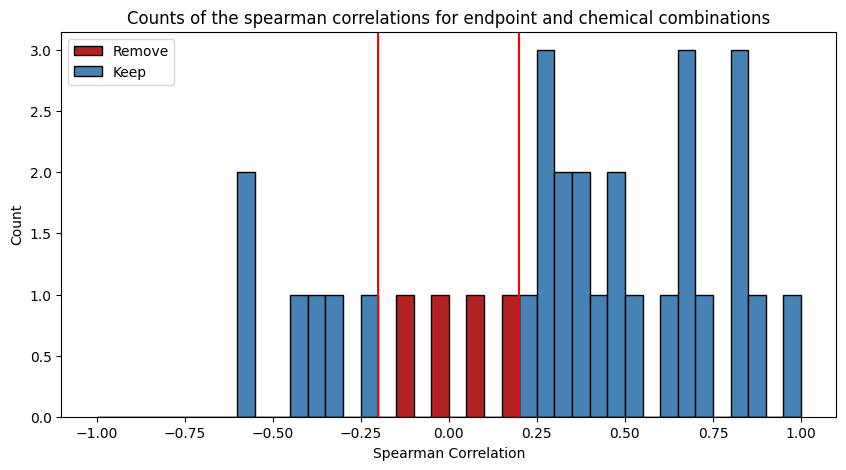

In [7]:
# View filter
con.filter_correlation_score(score = 0.2, diagnostic_plot = True, apply = False, direction = "between")
con.filter_correlation_score_plot

In [8]:
con.filter_correlation_score_df

,bmdrc.Endpoint.ID,Spearman,Filter
0,1 Endpoint3,0.300438,Keep
1,1 Endpoint4,-0.033786,Remove
2,10 Endpoint2,0.889052,Keep
3,11 Endpoint1,0.840001,Keep
4,11 Endpoint2,0.662190,Keep
5,12 Endpoint1,0.282044,Keep
6,12 Endpoint2,0.472117,Keep
7,12 Endpoint3,0.269781,Keep
8,12 Endpoint4,0.223964,Keep
9,13 Endpoint1,0.478249,Keep


In [9]:
# Apply the filter with defaults
con.filter_correlation_score(score = 0.2, apply = True, direction = "between")

## Module 4: Model Fitting

In [10]:
data = con.df[(con.df["Chemical ID"] == "12") & (con.df["Endpoint"] == "Endpoint1")]
data

,Chemical ID,Concentration_uM,Endpoint,Measurement,Notes,plate
0,12,0.0,Endpoint1,95.604752,NaN,NoPlate
1,12,0.0,Endpoint1,98.499077,NaN,NoPlate
2,12,0.0,Endpoint1,116.322091,NaN,NoPlate
3,12,0.0,Endpoint1,89.574080,NaN,NoPlate
4,12,10.0,Endpoint1,76.620770,NaN,NoPlate
5,12,10.0,Endpoint1,84.625593,NaN,NoPlate
6,12,10.0,Endpoint1,76.379208,NaN,NoPlate
7,12,10.0,Endpoint1,76.320669,NaN,NoPlate
8,12,50.0,Endpoint1,71.308802,NaN,NoPlate
9,12,50.0,Endpoint1,68.308431,NaN,NoPlate


In [14]:
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

# Save the selected fixed_intercept
fixed_intercept = 10

# Extract out the values
x = data[con._concentration].to_numpy()
y = data[con._response].to_numpy()

# Adjust by intercept
y = [val - fixed_intercept for val in y]

# Fit linear model without intercept and without fitting a linear regression model (include bias) again
model = make_pipeline(PolynomialFeatures(2, include_bias = False), LinearRegression(fit_intercept = False))
model.fit(x.reshape(-1, 1), y)
model = model
y_pred = model.predict(x.reshape(-1, 1)) + fixed_intercept

In [15]:
params = model.named_steps["linearregression"].coef_
params

array([ 0.80107131, -0.00134706])

In [ ]:
np.min(y_pred)

In [18]:
# Response of 88 

# Extract the roots with numpy (np. roots)

# params order: linear, quadratic, etc. which needs to be flipped. Add the y value to the end.
ordered_params = np.append(np.flip(params), 10)

np.roots(ordered_params)

array([606.9114318 , -12.23169497])